# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 03 - Hierarchical Models in PyMC3 

**Harvard University**<br>
**Spring 2022**<br>
**Instructors:** Mark Glickman and Pavlos Protopapas<br>
**Lab instructor and content:** Eleni Angelaki Kaxiras<br>

---

In [3]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from pymc3 import summary
from pymc3 import Model, Normal, HalfNormal, model_to_graphviz, HalfCauchy
from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats as stats
import pandas as pd
import seaborn as sns
%matplotlib inline 

import warnings
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.11.4


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20000;

<IPython.core.display.Javascript object>

### Learning Objectives

By the end of this lab, you should know how to create Bayesian hierarchical models in PyMC3 

**This lab maps to Homework 2.**

## Hierarchical Models

**Gelman et al.** famous radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Here we'll investigate this differences and try to make predictions of radonlevels in different county's based on the county itself and the presence of a basement.

![house](radon_house.jpg)

In [5]:
df = pd.read_csv('radon.csv', index_col=[0])
df['log_radon'] = df['log_radon'].astype('float')
county_names = df.county.unique()
county_idx = df.county_code.values

n_counties = len(df.county.unique())
df.head()

idnum state state2  stfips    zip  region  typebldg  floor  room basement  \
0  5081.0    MN     MN    27.0  55735     5.0       1.0    1.0   3.0        N   
1  5082.0    MN     MN    27.0  55748     5.0       1.0    0.0   4.0        Y   
2  5083.0    MN     MN    27.0  55748     5.0       1.0    0.0   4.0        Y   
3  5084.0    MN     MN    27.0  56469     5.0       1.0    0.0   4.0        Y   
4  5085.0    MN     MN    27.0  55011     3.0       1.0    0.0   4.0        Y   

   ... pcterr        adjwt  dupflag  zipflag  cntyfips  county     fips  \
0  ...    9.7  1146.499190      1.0      0.0       1.0  AITKIN  27001.0   
1  ...   14.5   471.366223      0.0      0.0       1.0  AITKIN  27001.0   
2  ...    9.6   433.316718      0.0      0.0       1.0  AITKIN  27001.0   
3  ...   24.3   461.623670      0.0      0.0       1.0  AITKIN  27001.0   
4  ...   13.8   433.316718      0.0      0.0       3.0   ANOKA  27003.0   

       Uppm  county_code  log_radon  
0  0.502054            0   0.832909  
1  0.502054            0   0.832909  
2  0.502054            0   1.098612  
3  0.502054            0   0.095310  
4  0.428565            1   1.163151  

[5 rows x 29 columns]

Each **row** in the dataframe represents the radon measurements for **one house** in a specific county including whether the house has a basement (floor = 0) or not (floor = 1). We are interested in whether having a basement increases the radon measured in the house.

To keep things simple let's keep only the following three variables: `county`, `log_radon`, and `floor`

In [6]:
# keep only these variables
data = df[['county', 'log_radon', 'floor']]
data.head()

county  log_radon  floor
0  AITKIN   0.832909    1.0
1  AITKIN   0.832909    0.0
2  AITKIN   1.098612    0.0
3  AITKIN   0.095310    0.0
4   ANOKA   1.163151    0.0

Let's check how many different counties we have. We also notice that they have a different number of houses. Some have a large number of houses measured, some only 1.

In [7]:
data['county'].value_counts().head(5)

ST LOUIS      116
HENNEPIN      105
DAKOTA         63
ANOKA          52
WASHINGTON     46
Name: county, dtype: int64

In [8]:
data['county'].value_counts()[-5:]

MILLE LACS         2
YELLOW MEDICINE    2
MAHNOMEN           1
WILKIN             1
MURRAY             1
Name: county, dtype: int64

In [9]:
# let's add a column that numbers the counties from 0 to n
# raw_ids = np.unique(data['county'])
# raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

# data['county_id'] = data['county'].map(raw2newid)
# data

### 1 - Pooling: Same Linear Regression for all

We can just pool all the data and estimate one big regression to asses the influence of having a basement on radon levels across all counties. Our model would be:

\begin{equation}
y_{i} = \alpha + \beta*floor_{i} 
\end{equation}

Where $i$ represents the measurement (house), and floor contains a 0 or 1 if the house has a basement or not. By ignoring the county feature, we do not differenciate on counties.

In [10]:
with pm.Model() as pooled_model:
    # common priors for all
    a = pm.Normal('a', mu=0, sigma=100)   
    b = pm.Normal('b', mu=0, sigma=100)

    # radon estimate
    radon_est = a + b*data['floor'].values

    # likelihood after radon observations
    radon_obs = pm.Normal('radon_obs', mu=radon_est,  
                           observed=data['log_radon']) # note here we enter the whole dataset

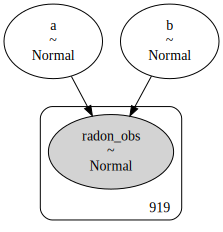

In [11]:
from pymc3 import model_to_graphviz
model_to_graphviz(pooled_model)

In [12]:
with pooled_model:
 
    pooled_trace = sample(2000, tune=1000, target_accept=0.9) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


DONE


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

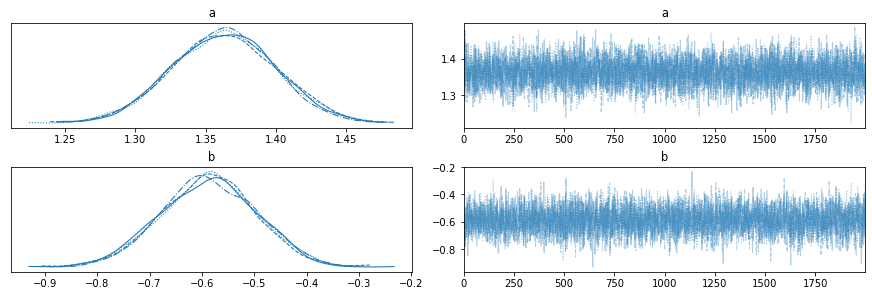

In [13]:
pm.traceplot(pooled_trace);

Remember, with the pooled model we have only one intercept, $\alpha$, and only one slope, $\beta$ for all the counties. Let's plot the regression lines.

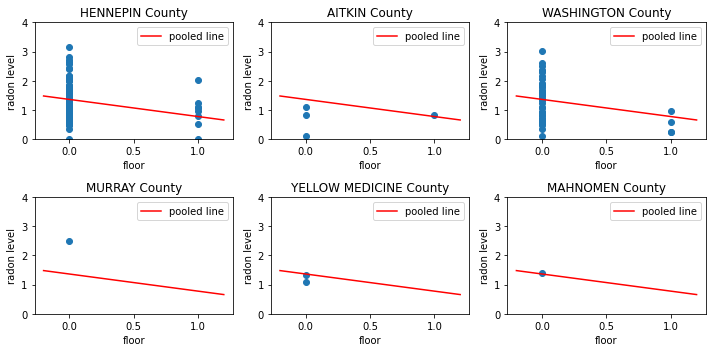

In [14]:
# plot just a subset of the countries
counties = ['HENNEPIN','AITKIN','WASHINGTON', 'MURRAY', 'YELLOW MEDICINE', 'MAHNOMEN']

plt.figure(figsize=(10,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    x = np.linspace(-0.2, 1.2)    
    radon_est = pooled_trace['a'].mean() + pooled_trace['b'].mean()*x
    subplt = plt.subplot(gs[i])

    subplt.set_ylim(0.,4.)
    subplt.scatter(county_data['floor'], county_data['log_radon'])
    subplt.plot(x, radon_est, c='r', label='pooled line');
    subplt.set_xlabel('floor', fontsize=10)
    subplt.set_ylabel('radon level', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()
    plt.tight_layout()

### 2 - Unpooling: Separate Linear Regression for each county 

We believe that different counties have different relationships of radon and basements. Our model would be:

\begin{equation}
radon_{i,c} = \alpha_c + \beta_c*floor_{i,c} 
\end{equation}

Where $i$ represents the measurement, $c$ the county, and floor contains a 0 or 1 if the house has a basement or not. 

Notice we have separate coefficients for each county in $a_c$ and $b_c$. They are totally different, they do not even come from the same distribution.

We will do this for only one county, as an example. We pick HENNEPIN county. 

In [15]:
# chose a county
county = 'MEEKER'
county_data = data.loc[data['county']==county]
county_data.head()

county  log_radon  floor
479  MEEKER   0.875469    0.0
480  MEEKER   1.386294    0.0
481  MEEKER   1.987874    0.0
482  MEEKER   0.788457    0.0
483  MEEKER   1.193922    0.0

In [16]:
#help(pm.Normal)

In [17]:
with pm.Model() as unpooled_model:
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)
    
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a)   
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b)

    radon_est = a + b*county_data['floor'].values

    radon_obs = pm.Normal('radon_like', mu=radon_est,  
                           observed=county_data['log_radon']) 

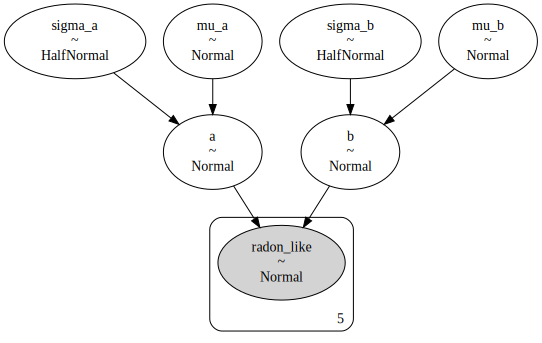

In [18]:
model_to_graphviz(unpooled_model)

In [19]:
with unpooled_model:
 
    unpooled_trace = sample(2000, tune=1000, target_accept=0.9) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
There were 698 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5199540285576106, but should be close to 0.9. Try to increase the number of tuning steps.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


DONE


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>]], dtype=object)

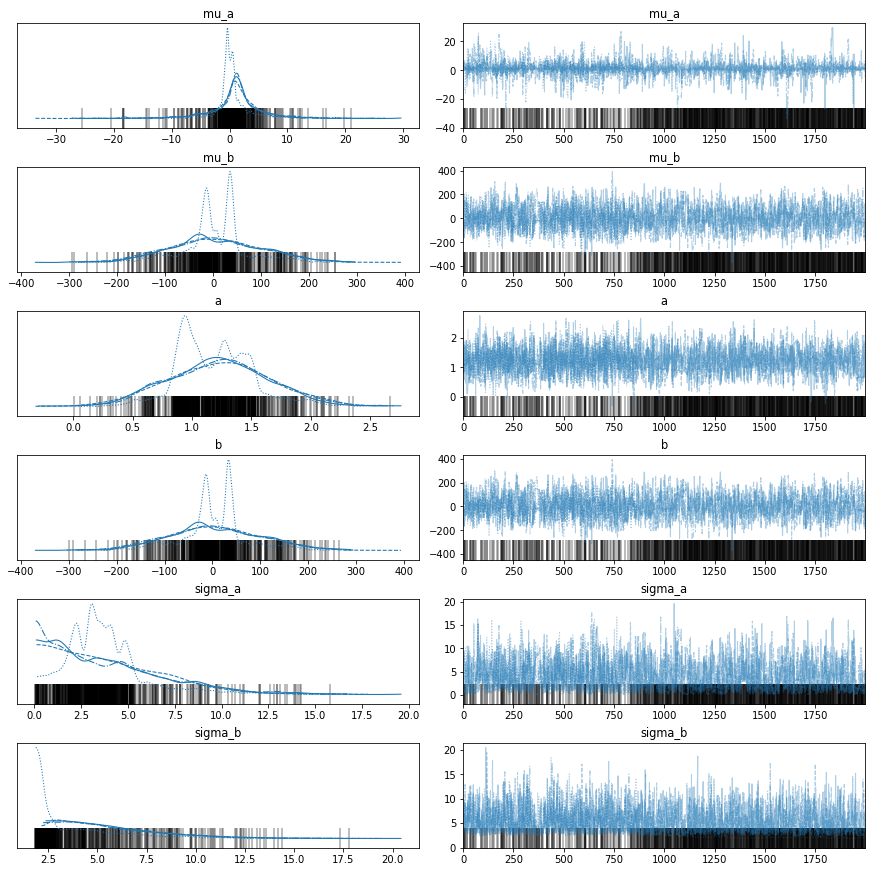

In [20]:
pm.traceplot(unpooled_trace);

Print the regression line for our chosen county alone.

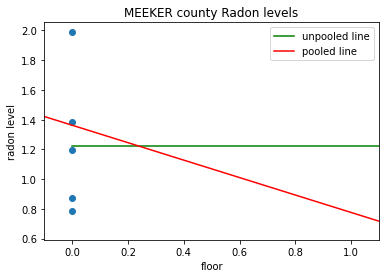

In [21]:
county = 'MEEKER'
county_data = data.loc[data['county']==county]

x = np.arange(len(county_data['floor'].values))
radon_est_unpooled = unpooled_trace['a'].mean() + unpooled_trace['b'].mean()*county_data['floor'].values

xx = np.linspace(-0.2, 1.2)    
radon_est_pooled = pooled_trace['a'].mean() + pooled_trace['b'].mean()*xx

plt.scatter(county_data['floor'], county_data['log_radon'])
plt.xlim(-0.1,1.1)
plt.xlabel('floor', fontsize=10)
plt.ylabel('radon level', fontsize=10)
plt.title(f'{str(county)} county Radon levels')
plt.plot(x, radon_est_unpooled, c='g', label='unpooled line');
plt.plot(xx, radon_est_pooled, c='r', label='pooled line');
plt.legend();

### 3 - Partial pooling: Hierarchical Regression (Varying-Coefficients Model)

Merely by the fact that all counties are counties, they share similarities, so there is a middle ground to both of these extremes. Specifically, we may assume that while $\alpha_c$ and $\beta_c$are different for each county as in the unpooled case, the coefficients are all drawn from the same distribution:

\begin{equation}
radon_{i,c} = \alpha_c + \beta_c*floor_{i,c} 
\end{equation}   

\begin{equation}
a_c \sim  \mathcal{N}(\mu_a,\,\sigma_a^{2})
\end{equation} 
\begin{equation}
b_c \sim  \mathcal{N}(\mu_b,\,\sigma_b^{2})
\end{equation}

where the common parameters are:
\begin{eqnarray}
\mu_a \sim  \mathcal{N}(0,\,10) \\
\sigma_a^2 \sim  |\mathcal{N}(0,\,10)| \\
\mu_b \sim  \mathcal{N}(0,\,10) \\
\sigma_b^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}

Add math for mu and sigma


The different counties are effectively sharing information through the commin priors. We are thus observing what is known as shrinkage; modeling the groups not as independent from each other, neither as a single group but rather as related.

NOTES

We saw that some counties had only one sample, so if that house is a really old with old lead pipes, our prediction will be that all houses in this county have radon. On the other extreme, if we have a newer house with no radon then again we will have missleading results. In one case, you will overestimate the bad quality and in the other underestimate it. Under a hierarchical model, the miss-estimation of one group will be offset by the information provided by the other groups. As always gathering more data helps if this is an option.

### Defining the Model for the Hierarchical Model 

In [22]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # beta for each county, distributed around group mean mu_b
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    #eps = pm.HalfCauchy('eps', 5.)

    radon_est = a[county_idx] + b[county_idx]*data['floor'].values

    # Data likelihood with sigma for random error
#     radon_like = pm.Normal('radon_like', mu=radon_est,
#                            sigma=eps, observed=data['log_radon'])

    # Data likelihood with sigma without random error
    radon_like = pm.Normal('radon_like', mu=radon_est, #sigma=eps, 
                           observed=data['log_radon'])

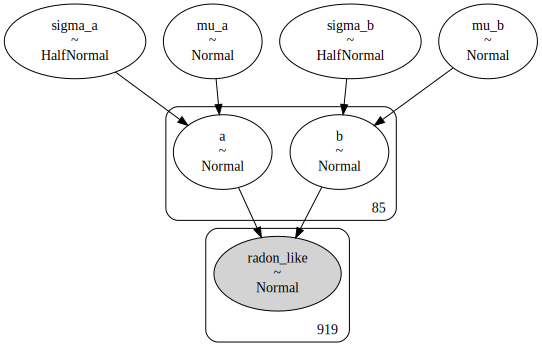

In [23]:
model_to_graphviz(hierarchical_model)

#### Inference 

In [23]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]


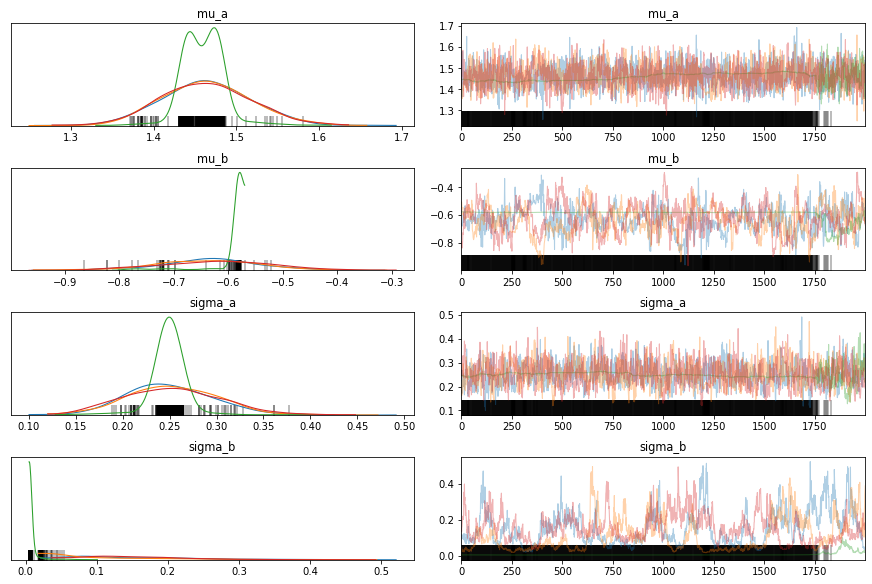

In [24]:
pm.traceplot(hierarchical_trace, var_names=['mu_a', 'mu_b',
                                            'sigma_a', 'sigma_b']);

In [25]:
results = pm.summary(hierarchical_trace) 
results[:10] 

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a  1.462  0.048   1.374    1.560      0.002    0.001     912.0   912.0   
mu_b -0.624  0.089  -0.824   -0.476      0.006    0.005     215.0   193.0   
a[0]  1.334  0.210   0.917    1.758      0.003    0.003    4753.0  2289.0   
a[1]  1.043  0.119   0.830    1.276      0.017    0.013      47.0    44.0   
a[2]  1.493  0.220   1.027    1.877      0.027    0.019      68.0    68.0   
a[3]  1.504  0.190   1.131    1.893      0.004    0.003    2658.0  2658.0   
a[4]  1.382  0.251   1.043    1.853      0.073    0.053      12.0    12.0   
a[5]  1.545  0.249   1.050    1.909      0.057    0.042      19.0    18.0   
a[6]  1.746  0.179   1.369    2.046      0.021    0.015      72.0    72.0   
a[7]  1.634  0.252   1.126    1.980      0.065    0.048      15.0    14.0   

      ess_bulk  ess_tail  r_hat  
mu_a     681.0    1786.0   1.06  
mu_b     224.0     379.0   1.09  
a[0]    3168.0    2972.0   1.20  
a[1]      55.0    2754.0   1.07  
a[2]      61.0    2436.0   1.09  
a[3]    1129.0    2511.0   1.17  
a[4]      12.0     378.0   1.22  
a[5]      21.0    2916.0   1.12  
a[6]      76.0    3192.0   1.08  
a[7]      17.0    1853.0   1.16

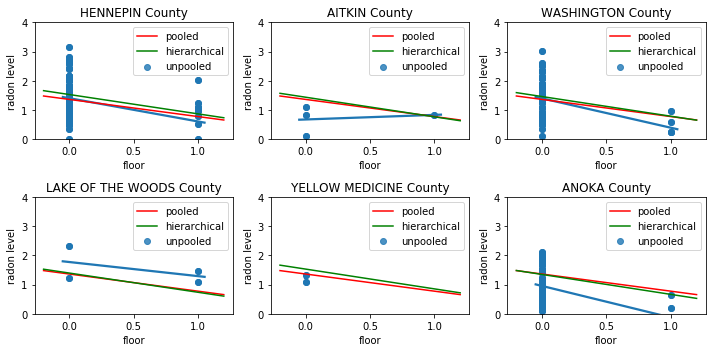

In [26]:
# plot just a subset of the countries
counties = ['HENNEPIN','AITKIN','WASHINGTON', 'LAKE OF THE WOODS', 'YELLOW MEDICINE', 'ANOKA']

plt.figure(figsize=(10,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    subplt = plt.subplot(gs[i])
    
    # pooled line (single values coeff for all)
    xx = np.linspace(-0.2, 1.2)    
    radon_est = pooled_trace['a'].mean() + pooled_trace['b'].mean()*xx
    
    radon_est_hier = np.mean(hierarchical_trace['a'][i]) + \
                      np.mean(hierarchical_trace['b'][i])*xx 

    # un-pooled (single subject)
    sns.regplot(x='floor', y='log_radon', ci=None, label='unpooled',
                data=county_data).set_title('County '+str(county))
    
    # hierarchical line
    subplt.set_ylim(0.,4.)
    subplt.scatter(county_data['floor'], county_data['log_radon'])
    subplt.plot(xx, radon_est, c='r', label='pooled');
    
    # plot the hierarchical, varying coefficient model
    subplt.plot(xx, radon_est_hier, c='g', label='hierarchical');
    
    subplt.set_xlabel('floor', fontsize=10)
    subplt.set_ylabel('radon level', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()
    plt.tight_layout()

This tutorial is modified from PyMC3 docs: https://docs.pymc.io/notebooks/GLM-hierarchical.html